# S&P 100 Optimization - Single Stock EWM

In [36]:
import os
import sys
import datetime as dt

config = {'name': 'rebalance_sim',
          'universe':
              {'path': '/Users/razvan/PyRepo/xr_simulation/data/SP100.csv',
               'ticker_col' : 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD",
               'freq': 'monthly'},
          'model':
              {'start_date': '20100102',
               'end_date': '20171231',
               'alpha': 0.1,
               'min_periods': 10,
               'horizon': 1,
               'lambda': 0.25,
               'data_dir': '/Users/razvan/PyRepo/xr_simulation/models/'},
          'risk': 'SS'
         }

In [37]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp
import alphamodel as am

# Train the alpha model
ss = am.SingleStockEWM(config)
ss.train(force=True)

# Realized Data for Simulation
returns = ss.realized['returns']
volumes = ss.realized['volumes']
sigmas = ss.realized['sigmas']

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key=ss.risk_free_symbol)

# Predicted Data for Optimization
ss.predict()
returns_pred = ss.predicted['returns']
volumes_pred = ss.predicted['volumes']
sigmas_pred = ss.predicted['sigmas']
covariance_pred = ss.predicted['covariance']

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1.,
                                   sigma=sigmas_pred,
                                   volume=volumes_pred)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

if config['risk'] == 'SS':
    risk_model = cp.FullSigma(covariance_pred)
#elif config['risk'] == 'FF':
#    risk_model = cp.FactorModelSigma(estimate_data.exposures, estimate_data.factor_sigma, estimate_data.idyos)
else:
    raise NotImplemented('The %s risk model is not implemented yet'.format(config['risk']))

results={}

Typical variance of returns: 0.00451237


In [1]:
#ss.prediction_quality()

# SPO Pareto search 

In [43]:
results_pareto={}

### Sparse Pareto

In [50]:
%%time
policies={}
gamma_risks_pareto=[0.1, 0.178, 0.316, 0.562, 1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
#gamma_tcosts_pareto=[5, 6, 7, 8]
gamma_holdings=[0.1, 1, 10, 100, 1000]
gamma_tcosts_pareto=[2.5, 5, 7.5, 10]

start_date = dt.datetime.strptime(config['model']['start_date'], '%Y%m%d') + dt.timedelta(days=10*40)
end_date = dt.datetime.strptime(config['model']['end_date'], '%Y%m%d')

for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
          cp.SinglePeriodOpt(returns_pred,
                             [gamma_risk*risk_model,gamma_tcost*optimization_tcost,\
                                       gamma_holding*optimization_hcost], 
                                [cp.LeverageLimit(1)])
# cp.LeverageLimit(1)
# cp.LongOnly()

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(),
                               simulator.run_multiple_backtest(1E8*w_b,
                                                               start_time=start_date.strftime('%Y-%m-%d'),
                                                               end_time=end_date.strftime('%Y-%m-%d'),
                                                               policies=policies.values(), ppy=12, parallel=True))))

CPU times: user 2.38 s, sys: 905 ms, total: 3.28 s
Wall time: 2min 35s


In [45]:
# Create result table
table=pd.DataFrame()
table['rebalance'] = ['monthly' for x in results_pareto.keys()]
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].annual_return) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].volatility) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv('spo_pareto_results_month.csv', float_format='%g')
table.style.format({'Return': "{:.2%}", 'Risk': '{:.2%}'})

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk,is_pareto
0,10,1,10,13.44%,14.49%,False
1,10,5,10,13.98%,13.94%,False
2,10,10,10,14.55%,12.78%,True
3,10,1000,10,13.86%,10.27%,True
4,10,100,10,8.45%,7.82%,False
5,100,1,10,4.08%,7.52%,False
6,100,5,10,4.38%,7.09%,False
7,100,10,10,5.23%,6.56%,False
8,100,1000,10,10.47%,6.43%,True
9,100,100,10,4.21%,5.02%,True


## Efficient Frontier

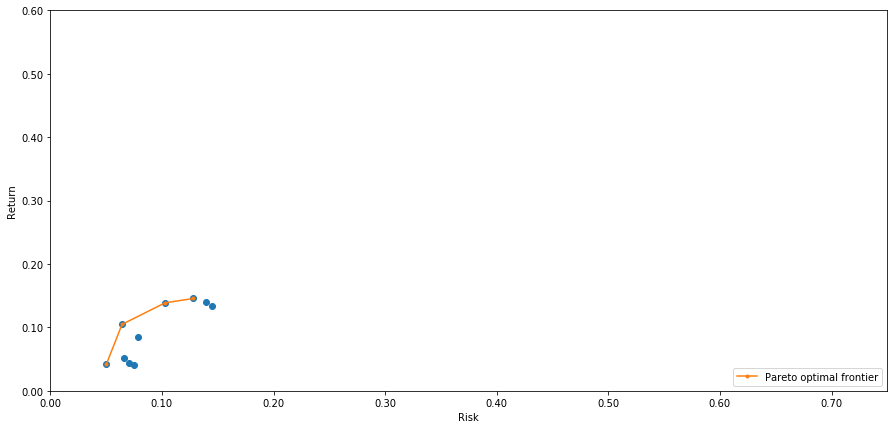

In [46]:
plt.figure(figsize=(15,7))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,0.75])
plt.ylim([0,0.6])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

plt.savefig('spo_pareto_month.png')

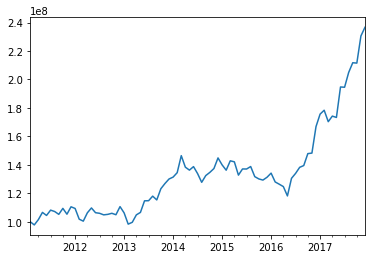

In [48]:
results_pareto[(10, 1, 10)].v.plot()

In [3]:
results_pareto[0].summary()

NameError: name 'results_pareto' is not defined